In [1]:
import os
import json
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from IPython.display import display, HTML

# Metrics obtained from an organizer of the Challenge
# https://github.com/plamere/RecsysChallengeTools/blob/master/metrics.py
from metrics import r_precision
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the playlist data:

### We start by loading some fraction of the "Million Playlist Dataset" into three separate containers that will soon be merged together.  

In [62]:
playlists = list()
tracks = dict()
map_pl = list()

max_files_for_quick_processing = 5


def process_track(track):
    key = track['track_uri']
    if not key in tracks:
        tk = dict()
        tk['track_artist_name'] = track['artist_name']
        tk['track_artist_uri'] = track['artist_uri']
        tk['track_name'] = track['track_name']
        tk['track_album_uri'] = track['album_uri']
        tk['track_duration_ms'] = track['duration_ms']
        tk['track_album_name'] = track['album_name']
        tracks[track['track_uri']] = tk
    return key


def process_playlist(playlist):
    pl = dict()
    pl['playlist_name'] = playlist['name']
    pl['playlist_collaborative'] = playlist['collaborative']
    pl['playlist_pid'] = playlist['pid']
    pl['playlist_modified_at'] = playlist['modified_at']
    pl['playlist_num_albums'] = playlist['num_albums']
    pl['playlist_num_tracks'] = playlist['num_tracks']
    pl['playlist_num_followers'] = playlist['num_followers']
    pl['playlist_num_edits'] = playlist['num_edits']
    pl['playlist_duration_ms'] = playlist['duration_ms']
    pl['playlist_num_artists'] = playlist['num_artists']
    if 'description' in playlist:
        pl['playlist_description'] = playlist['description']
    else:
        pl['playlist_description'] = ''
    trks = list()
    for track in playlist['tracks']:
        map_pl.append([playlist['pid'], track['track_uri']])
        trks.append(track['track_uri'])
        process_track(track)
    return pl

def process_mpd(path):
    count = 0
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        print(filename)
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            slice = json.loads(js)
            for playlist in slice['playlists']:
                playlists.append(process_playlist(playlist))
            count += 1
            if quick and count > max_files_for_quick_processing:
                break

quick = True
process_mpd('mpd.v1/data')

mpd.slice.0-999.json
mpd.slice.1000-1999.json
mpd.slice.10000-10999.json
mpd.slice.100000-100999.json
mpd.slice.101000-101999.json
mpd.slice.102000-102999.json


In [63]:
print("The number of playlists we have decided to load is:  ", len(playlists), "\n")
print("The number of unique tracks loaded is:  ", len(tracks), "\n")
print("The map that will connect tracks to playlist has length:  ", len(map_pl))

The number of playlists we have decided to load is:   6000 

The number of unique tracks loaded is:   121855 

The map that will connect tracks to playlist has length:   402808




### We turn dictionaries playlist dictionaries into a dataframe

In [64]:
playlist_df = pd.DataFrame(playlists)
display(playlist_df.head())
display(playlist_df.describe())

,playlist_collaborative,playlist_description,playlist_duration_ms,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_pid
0,false,,11532414,1493424000,Throwbacks,47,37,6,1,52,0
1,false,,11656470,1506556800,Awesome Playlist,23,21,5,1,39,1
2,false,,14039958,1505692800,korean,51,31,18,1,64,2
3,false,,28926058,1501027200,mat,107,86,4,1,126,3
4,false,,4335282,1401667200,90s,16,16,7,2,17,4


,playlist_duration_ms,playlist_modified_at,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_pid
count,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,1.571120e+07,1.476229e+09,49.919000,38.182167,17.721000,3.946167,67.134667,52832.833333
std,1.296439e+07,3.703559e+07,40.451726,30.582226,20.780146,152.699186,54.815825,48778.773904
min,5.556960e+05,1.299629e+09,2.000000,3.000000,2.000000,1.000000,5.000000,0.000000
25%,5.950795e+06,1.459620e+09,20.000000,16.000000,5.000000,1.000000,26.000000,1499.750000
50%,1.153929e+07,1.490746e+09,37.000000,30.000000,10.000000,1.000000,49.000000,55499.500000
75%,2.176090e+07,1.505434e+09,69.000000,51.000000,22.000000,1.000000,93.000000,101499.250000
max,7.143425e+07,1.509494e+09,237.000000,213.000000,184.000000,11745.000000,250.000000,102999.000000


### Now let's look at our tracks dataframe...

In [65]:
tracks_df = pd.DataFrame.from_dict(tracks, orient='index')
display(tracks_df.head())

,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name
spotify:track:000mA0etY38nKdvf1N04af,The Coronas,spotify:artist:2tppd6KkhK4ULAd217Ecq1,If I Gave Myself To Someone Else,spotify:album:662PiU3dRsilN0Gp87IiSF,214506,The Long Way
spotify:track:000xQL6tZNLJzIrtIgxqSl,ZAYN,spotify:artist:5ZsFI1h6hIdQRw2ti0hz81,Still Got Time,spotify:album:2kGUeTGnkLOYlinKRJe47G,188490,Still Got Time
spotify:track:0010mZpCCwlPwoBiBsjoac,Bombay Bicycle Club,spotify:artist:3pTE9iaJTkWns3mxpNQlJV,It's Alright Now,spotify:album:5oKWoolIuoWMG6AORvA9hL,249946,"So Long, See You Tomorrow"
spotify:track:0018QzCxmMrpa0FubbNdak,Los Invasores De Nuevo León,spotify:artist:5CGtBYmVPeLhI1kM2Fn9Gv,Embárgame A Mi,spotify:album:3W3HJXgsvDaZr8lxKqNN6m,147933,Embargame A Mi
spotify:track:001BVhvaZTf2icV88rU3DA,Amindi K. Fro$t,spotify:artist:3zQH24IzdAqloEl72e7hPD,Wet Jeans,spotify:album:7pZ8G0wWw7PLiECRnoaUbi,205255,Wet Jeans


### And playlist map

In [66]:
playlist_map_df = pd.DataFrame(map_pl, columns=['playlist_pid', 'track_uri'])
playlist_map_df.head()
#print(playlist_map_df.describe())

,playlist_pid,track_uri
0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI
1,0,spotify:track:6I9VzXrHxO9rA9A5euc8Ak
2,0,spotify:track:0WqIKmW4BTrj3eJFmnCKMv
3,0,spotify:track:1AWQoqb9bSvzTjaLralEkT
4,0,spotify:track:1lzr43nnXAijIGYnCT8M8H


### We set strings to lower case remove all non alphabetic characters and stop-words

In [67]:
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

playlist_df.playlist_description = playlist_df.playlist_description.apply(lambda x: x.lower())
playlist_df.playlist_description = playlist_df.playlist_description.str.replace('[^a-z]+', ' ')
playlist_df.playlist_description = playlist_df.playlist_description.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

playlist_df.playlist_name = playlist_df.playlist_name.apply(lambda x: x.lower())
playlist_df.playlist_name = playlist_df.playlist_name.str.replace('[^a-z]+', ' ')
playlist_df.playlist_name = playlist_df.playlist_name.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johndaciuk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


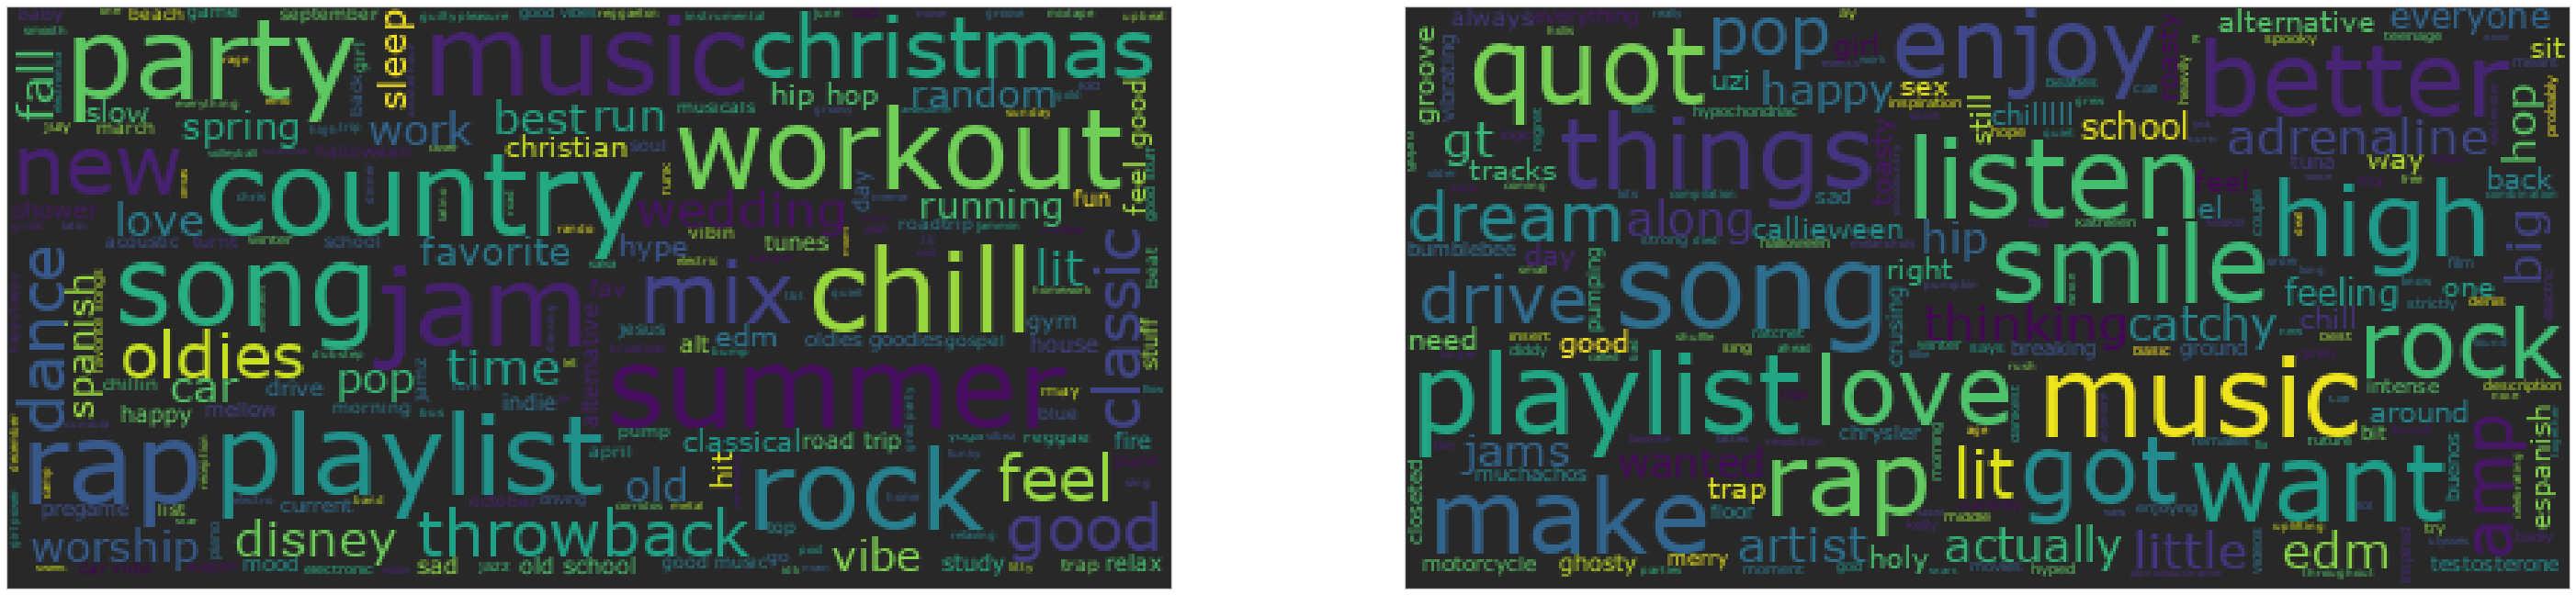

In [143]:
# pip install wordcloud
from wordcloud import WordCloud
fig, ax = plt.subplots(1,2, figsize = (50,50))
def generate_wordcloud(text, column): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                          relative_scaling = 0.1,
                          background_color = "#282828",
                          max_font_size = 40,
                          ).generate(text)
#     plt.figure(figsize=(15,10))
    ax[column].imshow(wordcloud)
    ax[column].set_xticks([])
    ax[column].set_yticks([])
#     plt.axis("off")
#     plt.show()

generate_wordcloud(' '.join(playlist_df.playlist_name), 0)

generate_wordcloud(' '.join(playlist_df.playlist_description), 1)

fig.savefig("wordcloud.png")


In [69]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cv_description = CountVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(1,1), analyzer='word')
dt_mat_description = cv_description.fit_transform(playlist_df.playlist_description)
playlist_df['playlist_description_frequency'] = list(dt_mat_description.toarray())

cv_name = CountVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(1,1), analyzer='word')
dt_mat_name = cv_name.fit_transform(playlist_df.playlist_name)
playlist_df['playlist_name_frequency'] = list(dt_mat_name.toarray())

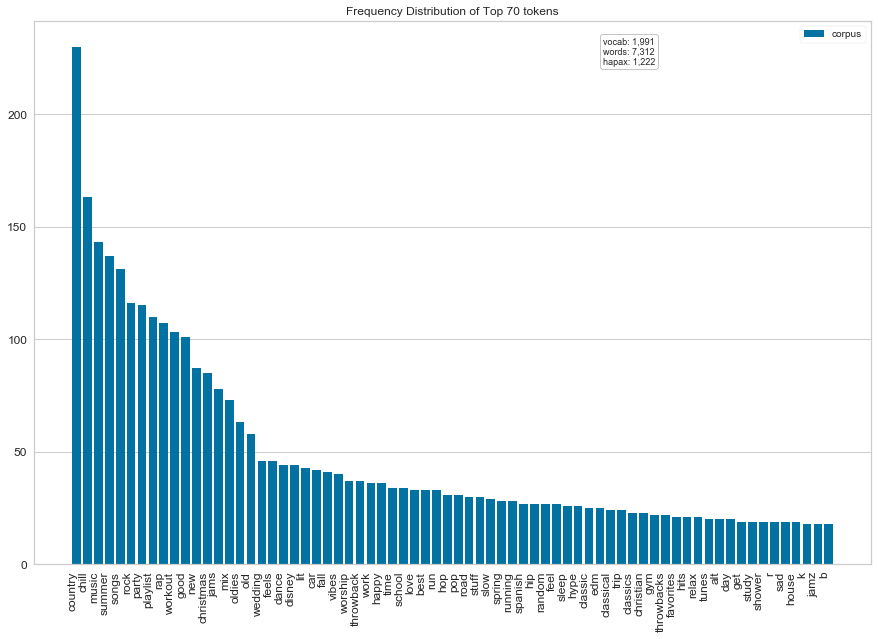

In [113]:
#pip install yellowbrick
from yellowbrick.text import FreqDistVisualizer

fig, ax = plt.subplots(1,1, figsize=(15,10))
colors = []
for i in range(70):
    colors.append("k")
visualizer = FreqDistVisualizer(features = cv_name.get_feature_names(), color = colors, n = 70, ax = ax, orient = "v",
                               kwargs = {"color": colors})
visualizer.fit(dt_mat_name)
ax.tick_params(labelsize = 12)
ax.legend(fontsize = "xx-small")
visualizer.poof()

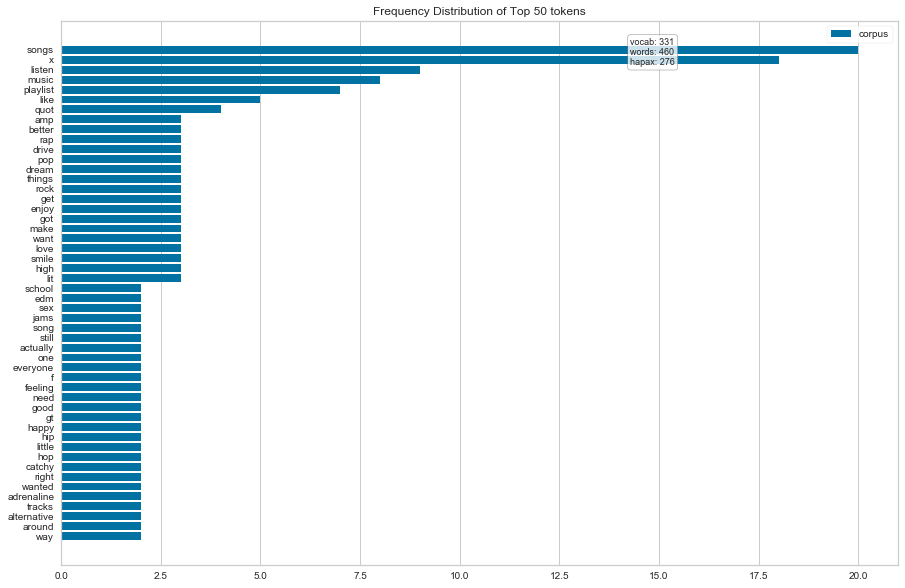

In [71]:
from yellowbrick.text import FreqDistVisualizer

plt.figure(figsize=(15,10))
visualizer = FreqDistVisualizer(features = cv_description.get_feature_names(), n = 100)
visualizer.fit(dt_mat_description)
visualizer.poof()

In [72]:
tfidf_transformer = TfidfTransformer()

tfidf_mat_description = tfidf_transformer.fit_transform(dt_mat_description)
playlist_df['playlist_description_tfidf_score']=list(tfidf_mat_description.toarray())

tfidf_mat_name = tfidf_transformer.fit_transform(dt_mat_name)
playlist_df['playlist_name_tfidf_score']=list(tfidf_mat_name.toarray())

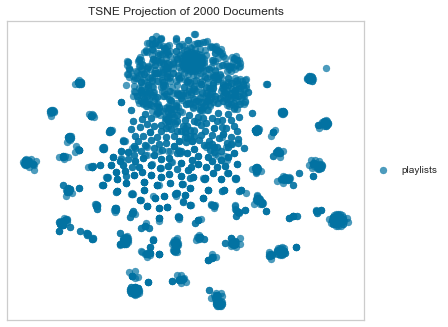

In [52]:
from yellowbrick.text import TSNEVisualizer
tsne = TSNEVisualizer(labels=["playlists"])
tsne.fit(tfidf_mat_name)
tsne.poof()

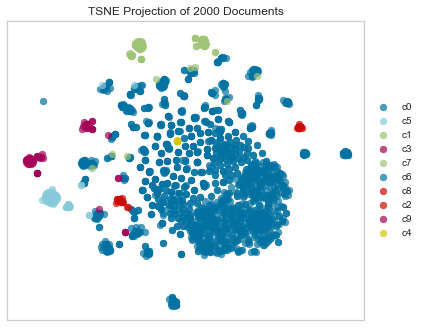

In [55]:
from sklearn.cluster import KMeans 
clusters = KMeans(n_clusters=10)
clusters.fit(tfidf_mat_name)
tsne = TSNEVisualizer()
tsne.fit(tfidf_mat_name, ["c{}".format(c) for c in clusters.labels_]) 
tsne.poof()

In [146]:
playlist_df["target"] = np.where(playlist_df.playlist_num_followers > 20, "Many Followers", 'Few Followers')
playlist_df.head()
mean_duration = np.mean(playlist_df["playlist_duration_ms"])
std_duration = np.std(playlist_df["playlist_duration_ms"])
conditions = [playlist_df["playlist_duration_ms"] > mean_duration + 1 * std_duration,
              playlist_df["playlist_duration_ms"] < mean_duration - 1 * std_duration]
choices = ["Long Songs", "Short Songs"]
playlist_df["playlist_ave_song_length"] = np.select(conditions, choices, default = "Average Length Songs")

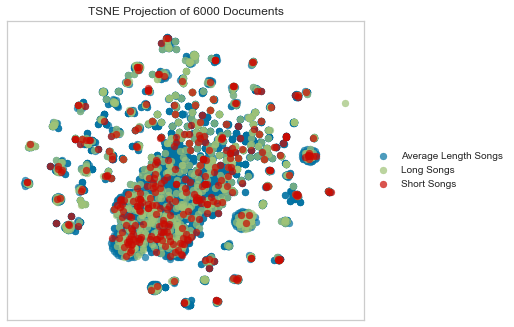

In [147]:
tsne = TSNEVisualizer()
labels = playlist_df["playlist_ave_song_length"]
tsne.fit(tfidf_mat_name, labels)
tsne.poof()

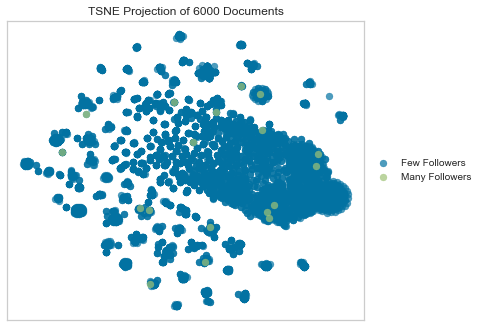

In [81]:
tsne = TSNEVisualizer()
labels = playlist_df["target"]
tsne.fit(tfidf_mat_name, labels)
tsne.poof()

In [46]:
bigrams_name_frequency = pd.DataFrame(dt_mat_name.todense(), index=playlist_df.index, columns=cv_name.get_feature_names())
bigrams_name_frequency['playlist_pid'] = playlist_df.playlist_pid
display(bigrams_name_frequency)

bigrams_desc_frequency = pd.DataFrame(tfidf_mat_description.todense(), index=playlist_df.index, columns=cv_description.get_feature_names())
bigrams_desc_frequency['playlist_pid'] = playlist_df.playlist_pid
display(bigrams_desc_frequency)

bigrams_name_tfidf_score = pd.DataFrame(dt_mat_name.todense(), index=playlist_df.index, columns=cv_name.get_feature_names())
bigrams_name_tfidf_score['playlist_pid'] = playlist_df.playlist_pid
display(bigrams_name_tfidf_score)

bigrams_desc_tfidf_score = pd.DataFrame(tfidf_mat_description.todense(), index=playlist_df.index, columns=cv_description.get_feature_names())
bigrams_desc_tfidf_score['playlist_pid'] = playlist_df.playlist_pid
display(bigrams_desc_tfidf_score)

,aa,aaa,abby,acoustic,adoracion,adore,adventure,af,afrikaans,afrobeats,...,yoga,youtubers,yrself,yuridia,zeros,zombies,zoned,zumba,zzzzzzzz,playlist_pid
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


,actually,adrenaline,along,always,artist,ay,back,badly,basic,beatles,...,use,uzi,vibrating,videos,wake,want,wanted,winter,x,playlist_pid
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


,aa,aaa,abby,acoustic,adoracion,adore,adventure,af,afrikaans,afrobeats,...,yoga,youtubers,yrself,yuridia,zeros,zombies,zoned,zumba,zzzzzzzz,playlist_pid
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


,actually,adrenaline,along,always,artist,ay,back,badly,basic,beatles,...,use,uzi,vibrating,videos,wake,want,wanted,winter,x,playlist_pid
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


### To organize the data, it is all merged into one dataframe

In [47]:
merged = pd.merge(
    pd.merge(
        tracks_df, playlist_map_df, left_index=True, right_on='track_uri'),
    playlist_df,
    on='playlist_pid')

merged.head()

,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name,playlist_pid,track_uri,playlist_collaborative,playlist_description,...,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_description_frequency,playlist_name_frequency,playlist_description_tfidf_score,playlist_name_tfidf_score
0,The Coronas,spotify:artist:2tppd6KkhK4ULAd217Ecq1,If I Gave Myself To Someone Else,spotify:album:662PiU3dRsilN0Gp87IiSF,214506,The Long Way,371,spotify:track:000mA0etY38nKdvf1N04af,false,,...,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Lewis Watson,spotify:artist:40ELTAg7Kg6vbWnlyx2n9R,stones around the sun,spotify:album:4cKBAg2zgjrVF2XefrW4WC,224440,the morning,371,spotify:track:0JGbwcwPV0VfuR4zDcZ9ce,false,,...,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Jaymes Young,spotify:artist:6QrQ7OrISRYIfS5mtacaw2,We Won't,spotify:album:6MuWCR3WPjwyKhqsTKLZ3z,240586,Feel Something,371,spotify:track:0Zge2Kfo3Yd9JOGnAmVPbb,false,,...,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,John Lucas,spotify:artist:7iEy8zKFtlYIINaxxLIyBk,This Will Be Our Home,spotify:album:2N7sEVVS3jKMJJuJi4v0UF,277160,Promised Land,371,spotify:track:1Sw7fhf7YJCD6GcWW0wETD,false,,...,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Hozier,spotify:artist:2FXC3k01G6Gw61bmprjgqS,Cherry Wine - Live,spotify:album:36k5aXpxffjVGcNce12GLZ,240147,Hozier,371,spotify:track:1ivHxaGL5ld9VS1zsYc4YN,false,,...,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [35]:
print("The shape of merged is: ", merged.shape)

The shape of merged is:  (134125, 18)


In [20]:
# Create Negative Samples
negative_samples = pd.DataFrame([])
for pid, df in tqdm(merged.groupby(["playlist_pid"])):
    negative_tracks = tracks_df.drop(df.track_uri).sample(df.shape[0])
    negative_playlist_tracks = pd.concat(
        [
            df.drop(list(tracks_df.columns) + ['track_uri'], axis=1).reset_index(
                drop=True), negative_tracks.reset_index()
        ],
        axis=1)
    negative_playlist_tracks.rename(columns={'index': 'track_uri'}, inplace=True)
    negative_samples = negative_samples.append(negative_playlist_tracks)


In [ ]:
# Provide labels
negative_samples['match'] = 0
merged['match'] = 1

In [ ]:
negative_samples.head()

In [ ]:
merged.head()

In [ ]:
negative_samples.head()

In [ ]:
merged.columns

In [ ]:
negative_samples.columns

In [ ]:
dataset = merged.append(negative_samples[merged.columns]).sort_values(by=['playlist_pid']).reset_index(drop=True)

In [ ]:
dataset.tail(32)

In [ ]:
# Include the features in the list below
features = [
    'playlist_duration_ms', 'playlist_num_albums', 'playlist_num_artists',
    'playlist_num_edits', 'playlist_num_followers', 'playlist_num_tracks',
    'playlist_pid', 'track_duration_ms'
]
data_x = dataset[features]
data_y = dataset.match
X_train, X_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.1, random_state=42, shuffle=True)

In [ ]:
X_test.head()

In [ ]:
y_test.head()
# y_test[y_test == 1].head()

In [ ]:
dataset.loc[X_test.head().index]

In [ ]:
y_test[y_test == 1].head()

In [ ]:
# 1. Calculate metric only on test set using the positive samples
#     a. Obtain unique playlists in the test set
#     b. For each playlist, obtain the positve songs.
#     c. Set both `target` and `prediction` as lists of the positive songs
#     d. For each playlist, calculate the r_precision. r_precision comes from the metrics.py file in the repo.

# 2. Train the X_train on the classifier. Obtain predictions for X_test

# 3. Repeat 1 above, now setting `predictions` as the list of songs "ranked by probability".

# 4. Calculate the r_precision metric based on your predicitons!

In [ ]:
# Create Negative Samples
negative_samples = pd.DataFrame([])
for pid, df in tqdm(merged.groupby(["playlist_pid"])):
    negative_tracks = tracks_df.drop(df.track_uri).sample(df.shape[0])
    negative_playlist_tracks = pd.concat(
        [
            df.drop(list(tracks_df.columns) + ['track_uri'], axis=1).reset_index(
                drop=True), negative_tracks.reset_index()
        ],
        axis=1)
    negative_playlist_tracks.rename(columns={'index': 'track_uri'}, inplace=True)
    negative_samples = negative_samples.append(negative_playlist_tracks)


In [ ]:
r_precisions = []
for pid, df in tqdm(X_test.groupby(["playlist_pid"])):
    probs = y_test.loc[df.index]  # change y_test to the output probs from clf
    targets = dataset.loc[probs[probs == 1].index].track_uri
    predictions = dataset.loc[probs[probs > 0.5].index].track_uri.unique()
    if len(targets) > 0:
        r_precisions.append(r_precision(targets, predictions))
np.mean(r_precisions)    

In [ ]:
lr_clf = LogisticRegression()
lr_clf = lr_clf.fit(X_train, y_train)

In [ ]:
# y_prob = lr_clf.predict_proba(X_test)
y_prob = pd.DataFrame(lr_clf.predict_proba(X_test), index=y_test.index)

In [ ]:
y_prob.head(10)

In [ ]:
y_test.head()

In [ ]:
y_pred = y_prob.idxmax(axis=1)

In [ ]:
r_precisions = []
for pid, df in tqdm(X_test.groupby(["playlist_pid"])):
    labels = y_test.loc[df.index]  # change y_test to the output probs from clf
    preds = y_pred.loc[df.index]
    targets = dataset.loc[labels[labels == 1].index].track_uri
    predictions = dataset.loc[preds[preds == 1].index].track_uri.unique()
    if len(targets) > 0:
        r_precisions.append(r_precision(targets, predictions))
np.mean(r_precisions)    

Question: Do playlist and track duration interact to influence whether a song should belong to a playlist `(match=1)` or whether a song should not belong to a playlist `(match=0)`?

In [ ]:
(dataset[dataset.match==1].playlist_duration_ms/dataset[dataset.match==1].playlist_num_tracks)

In [ ]:
plt.scatter(dataset[dataset.match == 1].playlist_duration_ms /
            dataset[dataset.match == 1].playlist_num_tracks,
            dataset[dataset.match == 1].track_duration_ms)
plt.scatter(dataset[dataset.match == 0].playlist_duration_ms /
            dataset[dataset.match == 0].playlist_num_tracks,
            dataset[dataset.match == 0].track_duration_ms)
plt.xlabel('Average Track Duration')
plt.ylabel('Track Duration')


A trend which might not be that strong to notice is that as the average track duration increases for a playlist, the propensity to see a track of long duration increases. However, this isn't the case with negative sample playlists, where in playlist of short length very long tracks can still be detected.

In [ ]:
plt.hist(dataset[dataset.match==1].playlist_duration_ms)
plt.hist(dataset[dataset.match==0].playlist_duration_ms)